In [1]:
import xarray as xr
#import cdsapi
import os
import matplotlib.pyplot as plt
import numpy as np
import iris
import xesmf as xe 

DATA_DIRECTORY = '/scratch/groups/earlew/yuchen/'

# Code to test rotation script

In [2]:
v_ds = xr.open_dataset(f'{DATA_DIRECTORY}/ERA5/10m_v_component_of_wind.nc')
u_ds = xr.open_dataset(f'{DATA_DIRECTORY}/ERA5/10m_u_component_of_wind.nc')
v_sps_ds = xr.open_dataset(f'{DATA_DIRECTORY}/ERA5/10m_v_component_of_wind_SPS.nc')
u_sps_ds = xr.open_dataset(f'{DATA_DIRECTORY}/ERA5/10m_u_component_of_wind_SPS.nc')

In [19]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

u_test, v_test = u_ds.u10.isel(expver=0, time=0), v_ds.v10.isel(expver=0, time=0)
u_test, v_test = u_test.sel(latitude=slice(-45,-90)), v_test.sel(latitude=slice(-45,-90))

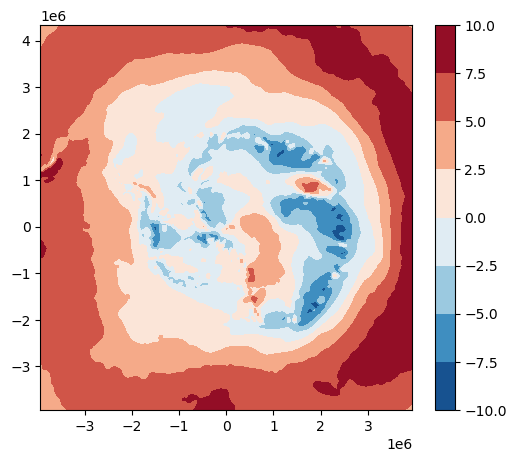

In [12]:

u_sps_plot = u_sps_ds.u10.isel(expver=0, time=0)
plt.figure(figsize=(6,5))
plt.contourf(u_sps_plot.xgrid, u_sps_plot.ygrid, u_sps_plot, cmap='RdBu_r')
plt.colorbar()

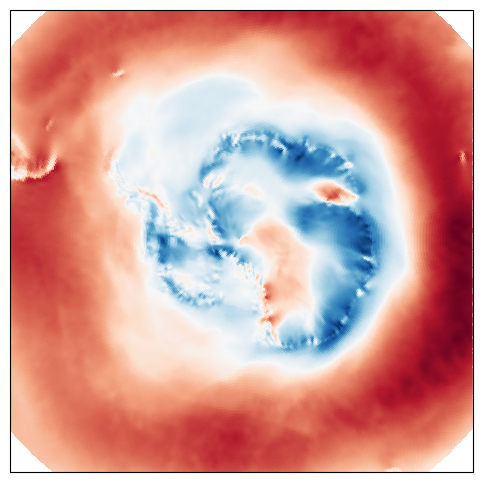

In [15]:
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': ccrs.SouthPolarStereo()})
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
ax.pcolormesh(u_test.longitude, u_test.latitude, u_test, transform=ccrs.PlateCarree(), cmap='RdBu_r')

In [2]:
era5_sic = xr.open_dataset(f'{DATA_DIRECTORY}/ERA5/sea_ice_cover_SPS.nc').siconc.isel(time=12, expver=0)
nsidc_sic = xr.open_dataset(f'{DATA_DIRECTORY}/NSIDC/seaice_conc_monthly_sh_197901_n07_v04r00.nc').cdr_seaice_conc_monthly.isel(tdim=0)

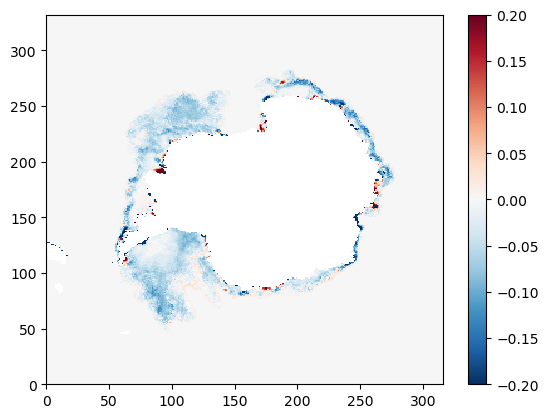

In [13]:
plt.pcolormesh(era5_sic.values - nsidc_sic.values, vmin=-0.2, vmax=0.2, cmap='RdBu_r')
plt.colorbar()

### Test calculating grid cell area